# Проект 
# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных:
- **Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSee`n — дата последней активности пользователя
- **Целевой признак**

- `Price` — цена (евро)

## Шаг 1 
### Имрорт необходимы библиотек и функции 

In [1]:
! pip install phik

In [2]:
#импорт необходимых библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from scipy import stats
import seaborn as sns
from typing import List
from scipy.stats import shapiro
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from time import time
import phik 
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings(action='ignore')



RANDOM_STATE = 42
TEST_SIZE = 0.2


from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings(action='ignore')



RANDOM_STATE = 42
TEST_SIZE = 0.2


In [3]:
def create_boxplot_and_histogram(data, column):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # График ящика с усами
    sns.boxplot(x=data[column], ax=axes[0])
    axes[0].set_title(f'Ящик с усами для {column}')
    axes[0].set_xlabel(column)

    # Гистограмма
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins, ax=axes[1])
    axes[1].set_title(f'{column} - Частота распределения', fontsize=18)
    axes[1].set_xlabel(column, fontsize=14)
    axes[1].set_ylabel('Частота', fontsize=14)

    plt.show()

In [4]:
def create_barplot(data, column):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, для которой нужно построить диаграмму.
    - title (str): Заголовок для столбчатой диаграммы.
    
    Output:
    None

    Description:
    Функция создает столбчатую диаграмму на основе данных из указанной колонки.
    """
    plt.figure(figsize=(10, 6))
    new_data = data[column].value_counts()
    df_new_data = new_data.reset_index()
    df_new_data.columns = [column, 'count']
    sns.barplot(x=column, y='count', data = df_new_data)
    plt.title(f'{column}.Плотность распределения')
    plt.xlabel(f'{column}')
    plt.ylabel(f'количество {column}')

In [5]:
def cat_num_col(df):
    """
    Input:
    - df(DataDrame): Исходный DataFrame с данными
    Output:
    - num_col_names(list) - список столбцов с количественными признаками
    - cat_col_names(list) - список столбцов с категориальными признаками

    Description:
    Функция возвращает списки с названиями столбцов категориальных и количественных признаков. id из списка удаляется

    """
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    #num_col_names.remove('id')
    return num_col_names, cat_col_names

In [6]:
def evaluate_pipeline(pipeline, param_grid, X_train, y_train):
    start_time = time()
    
    grid_search = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, cv=5,scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)
    
    end_time = time()
    execution_time = end_time - start_time
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    rmse = np.sqrt(abs(grid_search.best_score_))

    start_prediction_time = time()
    predictions = best_model.predict(X_train)
    end_prediction_time = time()
    prediction_time = end_prediction_time - start_prediction_time

    return best_params, execution_time, rmse, best_model, prediction_time

In [7]:
def plot_phik_heatmap(dataframe, interval_cols):
    """
    Input:
    - dataframe (DataFrame): Исходный DataFrame с данными.
    - interval_cols (list): Список названий интервальных признаков для расчета phik.
    
    Output:
    None
    
    Description:
    Эта функция вычисляет матрицу корреляций на основе phik для указанных интервальных признаков и строит тепловую карту на основе этой матрицы с использованием библиотеки seaborn.
    """
    # Вычисление phik_matrix
    phik_matrix = dataframe.phik_matrix(interval_cols=interval_cols)

    # Использование цветовой карты RdYlBu для лучшей визуализации
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Создание тепловой карты на основе phik_matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(phik_matrix, annot=True, cmap=cmap, center=0, square=True, linewidths=.5)
    plt.title('Phik. Тепловая карта')
    plt.show()

### Загрузка и предобработка данных 

In [8]:
try:
    df_auto = pd.read_csv('https://code.s3.yandex.net//datasets/autos.csv')
except FileNotFoundError:
    print('Что-то пошло не так')
    

In [9]:
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
df_auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных присутсвует 354369 данных, в некоторых колонках есть пропуски. Для удобства приведем названия колонок к нижнему регистру, а столбцы datecrawled, datecreated, lastseen, numberofpictures, postalcode,  registrationmonth сразу удалим. Так как они не имеют прямого отношения к образованию стоимости автомобиля. 

In [11]:
df_auto.columns = [col.lower() for col in df_auto.columns]


In [12]:
df_auto = df_auto.drop(
    ['datecrawled',
     'datecreated',
     'lastseen',
     'numberofpictures',
     'postalcode',
     'registrationmonth'],
    axis=1)

In [13]:
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


**Price**

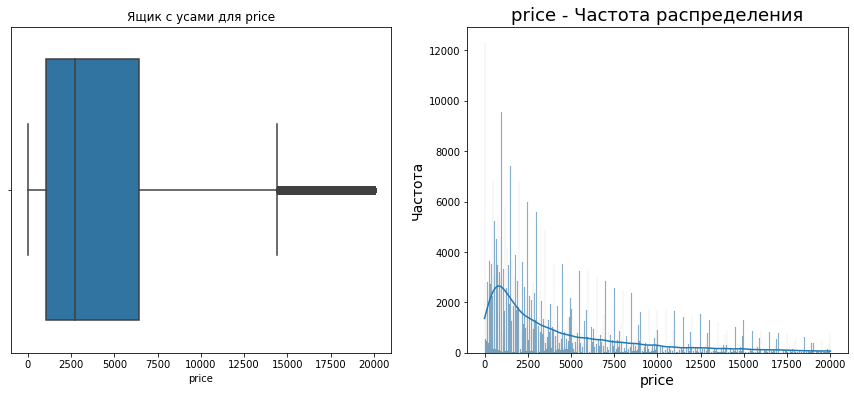

In [14]:
create_boxplot_and_histogram(df_auto, 'price')

In [15]:
df_auto['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Нулевой цены, скорее всего, быть не может. Но довольно низкие цены быть могут, если это старая машина: которая больше похожа на металлолом. Оставим только те, что выше 500 евро. 

In [16]:
df_auto = df_auto.query('price >= 500')

**registrationyear**

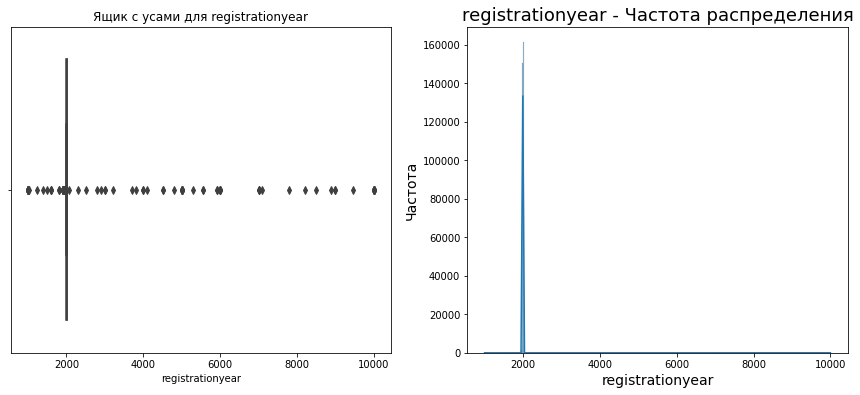

In [17]:
create_boxplot_and_histogram(df_auto, 'registrationyear')

In [18]:
df_auto['registrationyear'].describe()

count    318315.000000
mean       2004.164636
std          65.377755
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

первый в мире автомобиль с двигателем внутреннего сгорания сделали в 1885. Но эти автомобили совсем не похожи на те, что есть сейчас. Поэтому лучше будет оставить более современные автомобилы. Начиная с 1990 года и заканчивая прошлым годом

In [19]:
df_auto = df_auto.query('1990 <= registrationyear <= 2023')

**power**

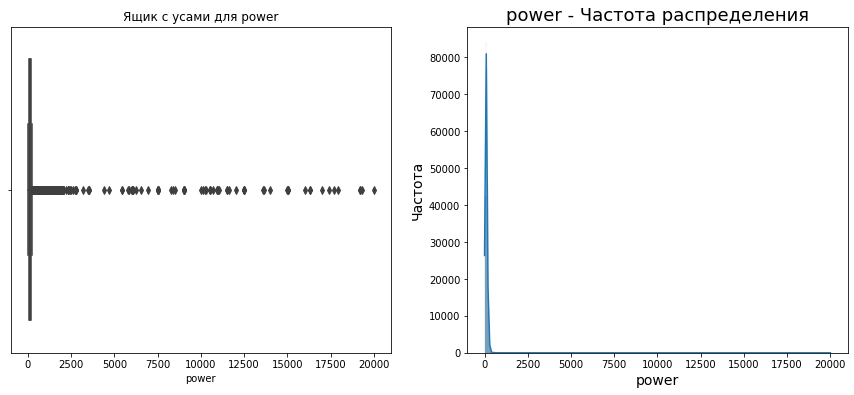

In [20]:
create_boxplot_and_histogram(df_auto, 'power')

Врятли машина с 0 силой будет хоть как-то ехать. По некоторым данным у легковых автомобилей лошадиные силы начинаются от 90. А все, что выше 1000 это уже спорткары и машины из очень дорогого сегмента. Поэтому удалим все, что не входит в этот диапозон

In [21]:
df_auto= df_auto.query('90< power <= 1000')

**kilometr**

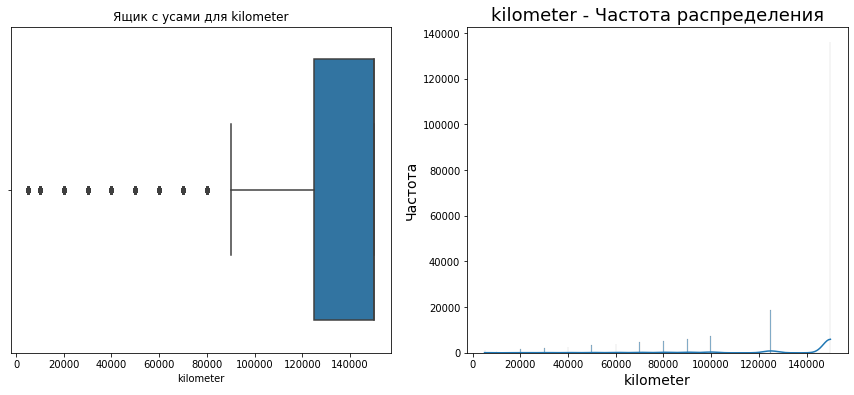

In [22]:
create_boxplot_and_histogram(df_auto, 'kilometer')

Хоть представить машимну с нулевым пробегом легко (вдруг ее для красоты купили) все равно по графикам видно, что это выбросы. Удалим все, что ниже 80000 км. 

In [23]:
df_auto= df_auto.query('kilometer >= 80000')

**Пропуски и дубликаты**

In [24]:
df_auto.isna().sum().sort_values()/df_auto.shape[0]*100

price                0.000000
registrationyear     0.000000
power                0.000000
kilometer            0.000000
brand                0.000000
gearbox              1.291985
model                3.549796
fueltype             5.480870
vehicletype          5.697735
repaired            13.430664
dtype: float64

Если при анкетировании не было указано, что был ремонт, можно предположить, что ремонта не было. Заменим пропуски на нет. А все остальные пропуски обработаем в пайплайне

In [25]:
df_auto['repaired'] = df_auto['repaired'].fillna('no')

Проверим есть ли дубликаты. Если они есть, то сразу удалим

In [26]:
dupl = df_auto.duplicated().sum()
print(f'Количество дублей: {dupl}')
if dupl > 0:
    df_auto.drop_duplicates(inplace=True)

Количество дублей: 25364


**Посмотрим на тепловую карту признаков**

In [27]:
num_auto, cat_auto = cat_num_col(df_auto)

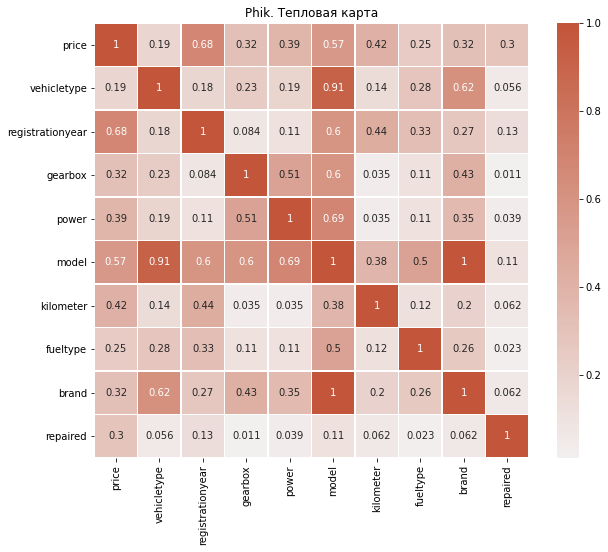

In [28]:
plot_phik_heatmap(df_auto, num_auto)

 Есть высокая зависимость между типом кузова и моделью, а также между брендом и моделью. Если это не будет сильно портить картину при обучении моделей, то ничего с этими признаками не будем делать

## Шаг 2 Модель

In [29]:
df_auto.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,no


Разделим данные на признаки, целевой признак и на выборки. Выделим в отдельные переменные колонки с категориальными и количествеными признаками. У категориальных поменяем тип данных

In [30]:
target = df_auto['price']
matrix = df_auto.drop('price', axis=1)

matrix_train, matrix_test, target_train, target_test = train_test_split(
    matrix, target,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

num_matrix, cat_matrix = cat_num_col(matrix)

matrix_train[cat_matrix] = matrix_train[cat_matrix].astype('category')

matrix_test[cat_matrix] = matrix_test[cat_matrix].astype('category')

Выполним кодировку признаков. Для категориальных будем использовать OrdinalEncoder, а для количественных StandardScaler

In [31]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe, cat_matrix),
    ('num', numeric_pipe, num_matrix)
], remainder='passthrough')



 Исследуем 3 модели. Возьмем дерево решений как более простую модель и 2 модели градиентного бустинга. Для исследования и выбора лучшей модели выберем метрику RMSE, а также будем смотреть на время обучения модели. Все эти данные сохраним в датафрейм для удобства. 

 **DecisionTreeRegressor**

In [32]:
pipeline_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ("decision_tree", DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Определение параметров для поиска
param_grid_tree = {
    'decision_tree__max_depth': [3, 5, 7],
    'decision_tree__min_samples_split': [2, 3, 4],
    'decision_tree__min_samples_leaf': [1, 2, 3]
}

best_params_tree, execution_time_tree, rmse_tree, model_tree, prediction_time_tree = \
evaluate_pipeline(pipeline_tree, param_grid_tree, matrix_train, target_train)


 **CatBoostRegressor**

In [33]:
pipeline_catboost = Pipeline([
    ('preprocessor', data_preprocessor),
    ("catboost", CatBoostRegressor(loss_function='RMSE', verbose=25))
])

param_grid_catboost = {
    'catboost__iterations': [50, 100, 150]
}


best_params_catboost, execution_time_catboost, rmse_catboost, model_catboost, prediction_time_catboost = \
evaluate_pipeline(pipeline_catboost, param_grid_catboost, matrix_train, target_train)



Learning rate set to 0.5
0:	learn: 3288.6223180	total: 63.1ms	remaining: 3.09s
25:	learn: 1905.6643939	total: 345ms	remaining: 319ms
49:	learn: 1816.1702748	total: 619ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3289.8693802	total: 12.2ms	remaining: 597ms
25:	learn: 1899.4269504	total: 305ms	remaining: 282ms
49:	learn: 1807.4717207	total: 579ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3286.3965251	total: 12.3ms	remaining: 604ms
25:	learn: 1900.3381136	total: 293ms	remaining: 270ms
49:	learn: 1812.0480277	total: 564ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3284.5362767	total: 11.5ms	remaining: 564ms
25:	learn: 1891.7048498	total: 303ms	remaining: 280ms
49:	learn: 1805.6576474	total: 570ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3292.4782380	total: 11.5ms	remaining: 562ms
25:	learn: 1898.5094366	total: 290ms	remaining: 267ms
49:	learn: 1810.5932640	total: 552ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3288.6223180	total: 11.7ms	remaining: 1.

**LGBMRegressor**

In [34]:
pipeline_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ("lgbm", LGBMRegressor())
])

param_grid_lgbm = {
    'lgbm__max_depth': [3, 5, 7]
}

best_params_lgbm, execution_time_lgbm, rmse_lgbm, model_lgbm, prediction_time_lgbm  = \
evaluate_pipeline(pipeline_lgbm, param_grid_lgbm, matrix_train, target_train)


In [35]:
data = {
    "model": ['tree', 'catboost', 'lgbm'],
    "execution_time": [execution_time_tree, execution_time_catboost, execution_time_lgbm],
    "train_rmse": [rmse_tree, rmse_catboost, rmse_lgbm],
    "prediction_time": [prediction_time_tree, prediction_time_catboost, prediction_time_lgbm]
}

df_all_model = pd.DataFrame(data)

df_all_model.head()


,model,execution_time,train_rmse,prediction_time
0,tree,17.755922,2330.594231,0.175766
1,catboost,39.282341,1770.215567,0.431298
2,lgbm,62.237846,1817.236568,1.015885


## Шаг 3. Выбор лучшей модели 

По результатам исследования дерево решений совмес не подходит, так как ее метрика больше 2500.  Лучшая модель по RMSE метрике CatBoostRegressor. Она также и самая быстрая по времени обучения. 
Посмотрим на ее гиперпараметры и выполним предсказание на тестовой выборке 

In [36]:
best_params_catboost

{'catboost__iterations': 150}

In [37]:
predictions = model_catboost.predict(matrix_test)
rmse_test = mean_squared_error(target_test, predictions, squared=False)
rmse_test

1746.262714970841

## Вывод

В ходе предобработки было сделано: 
- Перевели в нижний регистр названия признаков
- Удалили лишние признаки (datecrawled, datecreated, lastseen, numberofpictures, postalcode,registrationmonth)
- Удалили строки с аномальными значениями в столбцах price, registrationyear, power
- Заполнили пропуски столбце notrepaired
- Удалили 25364 дубликатов 

В ходе подготовки данных к обучению было сделано: 
- Преобразовали тип данных у категориальных данных
- Разделили данные на тренировочную и тестовую выборку 
- Выбрали кодировщики OrdinalEncider и StandartScaler 

В ходе обучения было сделано следующее: 
- Для обучения выбрали 3 модели DecisionTreeRegressor, CatBoostRegressor, Light Gradient Boosting Machine
- По метрике RMSE и времени обучения выбрали модель CatBoostRegressor и выполнили предсказание на тестовых данных 

Модель CatBoostRegressor:
- train_rmse 1770.215567
- execution_time 38.552472 сек.
- prediction_time 0.416134 сек. 
- best_params iterations: 150

**Значение RMSE лучшей модели на тестовой выборке - 1746**

**Таким образом заказчику можно порекомендовать модель градиентного бустинга CatBoostRegressor**
